# Model Selection, Comparison and Cross Validation

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV 
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error,mean_squared_log_error , r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def get_grid_cv(X_train,y_train,model,param_grid,fold,core):
    grid_search = GridSearchCV(model, param_grid, cv=fold,
    scoring='neg_mean_squared_error',n_jobs = core,verbose =2) 
    grid_search.fit(X_train,y_train)
    return grid_search

def get_measure(y_test,y_pred):
    RMSE =np.sqrt(mean_squared_error(y_test,y_pred))
    RMSLE=np.sqrt(mean_squared_log_error(y_test,y_pred))
    R_score = r2_score(y_test,y_pred)
    print('RMSE:',RMSE,'\nRMSLE:',RMSLE,'\nR2:',R_score)

def show_cv_results(grid): 
    c = grid.cv_results_
    for mean_score, params in zip(c["mean_test_score"], c["params"]): 
        print(np.sqrt(-mean_score), params)
        

In [5]:
df_final = pd.read_csv('cleanned_500_final.csv')

In [5]:
df_final.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'visib', 'wdsp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'Hour', 'distance_in_km', 'travel_time',
       'week_index', 'rain_Light', 'rain_Moderate', 'rain_No', 'rush_hour_ind',
       'avg_travel_time', 'avg_hr_travel_time', 'avg_trip_dist',
       'avg_hr_trip_dist', 'avg_fare_amount', 'avg_hr_fare_amount'],
      dtype='object')

In [8]:
X = df_final.drop(['travel_time'],axis =1)
y = df_final['travel_time']

## Linear Regression

In [9]:
X_lr = df_final.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude','travel_time'], axis=1)
X_scaled = preprocessing.scale(X_lr)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,y, test_size=0.2, random_state=42)

linear_clf = LinearRegression()
linear_clf.fit(X_train,y_train)
y_pred = linear_clf.predict(X_test)

In [10]:
#rmsle = np.sqrt(mean_squared_log_error(y_test,y_pred))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print('RMSE:',rmse,'\nr2:',r2)

RMSE: 305.82654604003386 
r2: 0.644091905678726


## Lasso CV

In [11]:
alphas = np.linspace(0.001,1,100)
X_scaled = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
lasso_lr = LassoCV(alphas=alphas, cv=5, random_state=0, max_iter=1000)
lasso_lr.fit(X_train, y_train)
y_pred = lasso_lr.predict(X_test)

In [12]:
print('Best alpha from CV :',lasso_lr.alpha_)

Best alpha from CV : 0.001


In [13]:
#rmsle = np.sqrt(mean_squared_log_error(y_test,y_pred))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print('RMSE:',rmse,'\nr2:',r2)

RMSE: 304.2269750423208 
r2: 0.6478051965053115


## Decision Tree

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
tr_reg = DecisionTreeRegressor()

In [34]:
tr_reg.fit(X_train,y_train)
y_pred = tr_reg.predict(X_test)

In [35]:
get_measure(y_test,y_pred)

RMSE: 371.4175069202242 
RMSLE: 0.49889966815415265 
R2: 0.4750568820586071


## Random Forest GridSearchCV

### If you want to do CV, Please set RunCV = True

In [7]:
RunCV = False #CV consumes time and memory

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### Tuning max_features

In [8]:
if RunCV:
    grid_max_features= get_grid_cv(X_train,y_train,RandomForestRegressor(),
                               param_grid = {'max_features':['sqrt','log2']},fold=5,core =2)
    #joblib.dump(grid_max_features, 'Grid_cv_max_features_result')
    grid_max_features.best_params_

### Tuning n_estimators

In [5]:
if RunCV:
    grid_n_estimators = get_grid_cv(X_train,y_train,RandomForestRegressor(max_features='sqrt'),param_grid = {'n_estimators':[10,50,100,150]},fold=5,core=1)
    #joblib.dump(grid_n_estimators, 'Grid_cv_n_estimators_result')
    grid_n_estimators.best_params_

### Tuning max_depth

In [9]:
if RunCV:
    grid_max_depth = get_grid_cv(X_train,y_train,RandomForestRegressor(max_features='sqrt',n_estimators=150),param_grid = {'max_depth':[10,15,20,25,30,35,40,45,50]},fold=5,core=1)
    #joblib.dump(grid_max_depth, 'Grid_cv_max_depth_result')
    grid_max_depth.best_params_

#### From GridSearchCV  we pick 'max_features': 'sqrt' , 'n_estimators': 150 , 'max_depth' : 40

In [17]:
forest_reg = RandomForestRegressor(max_depth=40,max_features='sqrt',n_estimators=150)
forest_reg.fit(X_train,y_train)
y_pred =forest_reg.predict(X_test)
get_measure(y_test,y_pred)

RMSE: 254.2352070281285 
RMSLE: 0.3575503562982025 
R2: 0.7540431682222308


In [20]:
feature_importance = forest_reg.feature_importances_

In [21]:
feature_importance

array([0.0331606 , 0.02580982, 0.03060324, 0.03131921, 0.02149929,
       0.01136471, 0.01796823, 0.00148893, 0.0024739 , 0.00112398,
       0.05033244, 0.18990001, 0.00436745, 0.00230534, 0.00182467,
       0.00258025, 0.00881187, 0.14210641, 0.1008897 , 0.09479205,
       0.04373336, 0.11434854, 0.067196  ])

In [22]:
feat = pd.DataFrame(feature_importance)
feat_name = pd.DataFrame(X.columns)
feat_df = pd.concat([feat_name,feat],axis=1)
feat_df.columns = ["feature","feature_score"]
feat_df =feat_df.sort_values(by = "feature_score")
feat_df=feat_df.reset_index(drop=True)

### Top 15 features

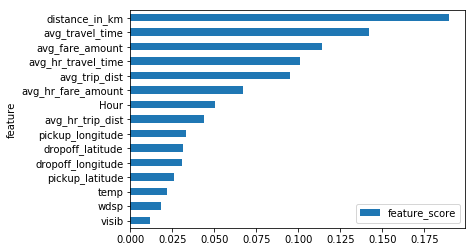

In [31]:
feat_df[-15:].plot.barh(x= 'feature',y = 'feature_score',align='center')

In [74]:
aaa = [1,2,3,4,5]

In [81]:
All_R2 = pd.DataFrame(np.array([0.64,0.65,0.47, 0.75]))
R2_name = pd.DataFrame(['Linear','Lasso','Decision_Tree','Random_Forest'])
R2_bar = pd.concat([R2_name,All_R2],axis=1)
R2_bar.columns = ["Models","R2"]
R2_bar =R2_bar.sort_values(by = "R2")
R2_bar=R2_bar.reset_index(drop=True)

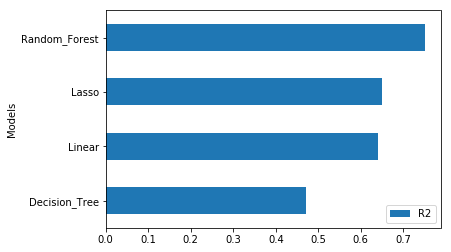

In [85]:
R2_bar.plot.barh(x= "Models",y = 'R2',align='center')

### From the R2 plot. The Random_Forest performaces best

In [3]:
All_RMSE = pd.DataFrame(np.array([305.82,304.23,371.41,254.24]))
RMSE_name = pd.DataFrame(['Linear','Lasso','Decision_Tree','Random_Forest'])
RMSE_bar = pd.concat([RMSE_name,All_RMSE],axis=1)
RMSE_bar.columns = ["Models","RMSE"]
RMSE_bar =RMSE_bar.sort_values(by = "RMSE",ascending=False)
RMSE_bar=RMSE_bar.reset_index(drop=True)

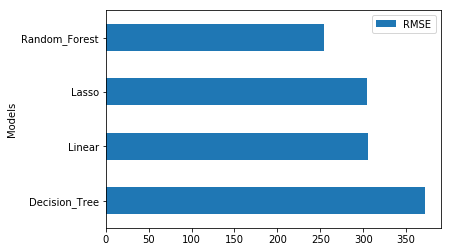

In [4]:
RMSE_bar.plot.barh(x= "Models",y = 'RMSE',align='center')

#### From the RMSE plot. The Random_Forest performaces best

## Testing

### Combine weather data

In [36]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pygeohash as pgh
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="4990-52a2635c2722.json"

In [37]:
from google.cloud import bigquery
client = bigquery.Client()
query=(
'''
select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
from `bigquery-public-data.noaa_gsod.gsod2015` where stn='725053'
''')

weather_2015 = pd.io.gbq.read_gbq(query,dialect='standard')

In [38]:
df_test = pd.read_csv('APM4990_final_test_data_filtered.csv')

In [39]:
df_test.insert(loc=0,column = 'datetime', value =pd.to_datetime(df_test['pickup_datetime']))
df_test.insert(loc = 0, column = 'date_of_year2',value=df_test['datetime'].apply(lambda x: x.strftime('%Y-%m-%d')))
df_test = pd.merge(df_test, weather_2015, how='left', on=['date_of_year2'])
df_test['Hour']=df_test.datetime.dt.hour
df_test['week']=df_test.datetime.dt.dayofweek
df_test['week_index']= df_test['week'].apply(lambda x: 0 if x==5 or x==6 else 1 )
df_test = df_test.drop(['date_of_year2','pickup_datetime','passenger_count','year','da','week'],axis=1)
df_test.rename(columns={'datetime':'pickup_datetime'}, inplace=True)

In [69]:
def date_trans(date):
    return pd.to_datetime(date).strftime("%Y-%m-%d %H:%M:%S")

In [70]:
df_test['pickup_datetime'] = df_test.apply(lambda x: date_trans(x['pickup_datetime']),axis=1)

In [71]:
df_test.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,mo,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets,Hour,week_index,rain_Light,rain_Moderate,rain_No,rush_hour_ind,pickup_geohash,dropoff_geohash,gh
0,2018-06-15 21:52:45,40.702740,-74.011650,40.773361,-73.990311,06,66.8,9.8,3.3,0.00,0,0,0,21,1,0,0,1,0,dr5rec,dr5ruq,dr5recdr5ruq
1,2008-11-15 02:22:25,40.733608,-74.003098,40.836803,-73.941643,11,51.9,10.0,4.0,0.00,0,0,0,2,0,0,0,1,0,dr5rsp,dr72m6,dr5rspdr72m6
2,2013-02-15 04:11:11,40.730911,-74.001442,40.665699,-73.956909,02,16.1,10.0,8.8,0.00,0,0,0,4,1,0,0,1,0,dr5rsn,dr5rm4,dr5rsndr5rm4
3,2023-07-15 09:14:04,40.774078,-73.874550,40.749939,-73.991203,07,76.7,10.0,4.1,0.00,0,0,0,9,1,0,0,1,1,dr5ryy,dr5ru6,dr5ryydr5ru6
4,2007-01-15 18:06:43,40.791588,-73.964874,40.792084,-73.968254,01,20.7,9.7,9.5,0.05,0,0,0,18,1,1,0,0,1,dr72hc,dr72hc,dr72hcdr72hc


### Construct testing features

In [40]:
from math import radians, cos, sin, asin, sqrt,acos
def RADIANS(x):
    return acos(-1)*x / 180
def RADIANS_TO_KM(x):
    return 111.045 * 180 * x / acos(-1)
def HAVERSINE(lat1,long1,lat2,long2):    
    distance =  RADIANS_TO_KM(
    acos(round(cos(RADIANS(lat1)) * cos(RADIANS(lat2)) *
         cos(RADIANS(long1) - RADIANS(long2)) +
         sin(RADIANS(lat1)) * sin(RADIANS(lat2)),15)))
    return distance


def rain_level(prcp):
    if prcp==0.0:
        return 'No'
    elif (prcp>0.0) & (prcp<0.098):
        return 'Light'
    elif (prcp>=0.098) & (prcp<0.39):
        return 'Moderate'
    else:
        return 'Heavy'
    

In [41]:
df_test['rain_level'] = df_test.apply(lambda x: rain_level(x['prcp']),axis=1)

In [42]:
df_test = pd.get_dummies(df_test,columns=['rain_level'],prefix=['rain'],drop_first=True)

In [43]:
rush_hour = [7,8,9,10,15,16,17,18,19]
df_test['rush_hour_ind']=df_test['Hour'].apply(lambda x: 1 if x in rush_hour else 0)

In [44]:
# We obtain geohash with precision = 6 for all data
df_test['pickup_geohash'] = df_test.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df_test['dropoff_geohash'] = df_test.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)
df_test['gh'] = df_test['pickup_geohash'] + df_test['dropoff_geohash']
df_test_match = df_test[['pickup_datetime','gh','Hour']]
df_test_match['data_index'] = 0

In [72]:
df_train = pd.read_csv('df_final_w.csv')

In [47]:
import datetime
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime']) - datetime.timedelta(days=365)

In [48]:
df_train_match = df_train[['pickup_datetime','gh','Hour','avg_travel_time','avg_hr_travel_time','avg_trip_dist','avg_hr_trip_dist','avg_fare_amount','avg_hr_fare_amount']]
df_train_match['data_index'] = 1
df_train_match.head()

,pickup_datetime,gh,Hour,avg_travel_time,avg_hr_travel_time,avg_trip_dist,avg_hr_trip_dist,avg_fare_amount,avg_hr_fare_amount,data_index
0,2015-01-24 14:25:00,dr5rswdr5rgb,14,578.157895,567.000000,1.717895,1.583333,8.710526,8.500000,1
1,2015-01-24 14:45:02,dr5reudr5rsp,14,486.537313,395.250000,1.596567,1.465000,7.888060,7.125000,1
2,2015-01-24 14:03:03,dr5ru9dr5rvn,14,626.939394,669.000000,2.404848,2.672000,10.070707,10.700000,1
3,2015-01-24 14:16:17,dr5rutdr5rur,14,466.283019,571.428571,1.176981,1.275714,7.103774,7.928571,1
4,2015-01-24 14:12:41,dr5rvpdr5rvj,14,398.503185,492.708333,1.020223,0.950417,6.442675,6.937500,1


In [51]:
df_merge = pd.concat([df_test_match,df_train_match], axis=0, ignore_index=True)

In [ ]:
df_merge['avg_travel_time'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_travel_time'].fillna(method='ffill')
df_merge['avg_trip_dist'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_trip_dist'].fillna(method='ffill')
df_merge['avg_fare_amount'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_fare_amount'].fillna(method='ffill')

In [ ]:
df_merge['avg_hr_travel_time'] = df_merge.sort_values('pickup_datetime').groupby(['gh','Hour'])['avg_hr_travel_time'].fillna(method='ffill')
df_merge['avg_hr_trip_dist'] = df_merge.sort_values('pickup_datetime').groupby(['gh','Hour'])['avg_hr_trip_dist'].fillna(method='ffill')
df_merge['avg_hr_fare_amount'] = df_merge.sort_values('pickup_datetime').groupby(['gh','Hour'])['avg_hr_fare_amount'].fillna(method='ffill')

In [ ]:
df_merge_test = df_merge[df_merge['data_index'] == 0]

In [ ]:
df_test['avg_fare_amount'] = df_merge_test['avg_fare_amount']
df_test['avg_hr_fare_amount'] = df_merge_test['avg_hr_fare_amount']
df_test['avg_hr_travel_time'] = df_merge_test['avg_hr_travel_time']
df_test['avg_hr_trip_dist'] = df_merge_test['avg_hr_trip_dist']
df_test['avg_travel_time'] = df_merge_test['avg_travel_time']
df_test['avg_trip_dist'] = df_merge_test['avg_trip_dist']

In [ ]:
df_test.isnull().sum()

In [ ]:
df_test = df_test.fillna(0)

In [ ]:
df_final = df_test.drop(['pickup_datetime','pickup_geohash','dropoff_geohash','gh','prcp','mo'],axis=1)

In [ ]:
df_final['distance_in_km'] = df_final.apply(lambda x: HAVERSINE(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis=1)

## Predicting

In [4]:
df_test = pd.read_csv('final_test_df.csv')

In [6]:
df = pd.read_csv('df_final_w.csv')

In [15]:
df_test.shape

(694047, 23)

In [11]:
df_test.columns

Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'temp', 'visib', 'wdsp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'Hour', 'week_index', 'rain_Light', 'rain_Moderate',
       'rain_No', 'rush_hour_ind', 'avg_fare_amount', 'avg_hr_fare_amount',
       'avg_hr_travel_time', 'avg_hr_trip_dist', 'avg_travel_time',
       'avg_trip_dist', 'distance_in_km'],
      dtype='object')

In [14]:
X.columns

Index(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'temp', 'visib', 'wdsp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'Hour', 'week_index', 'rain_Light', 'rain_Moderate',
       'rain_No', 'rush_hour_ind', 'avg_fare_amount', 'avg_hr_fare_amount',
       'avg_hr_travel_time', 'avg_hr_trip_dist', 'avg_travel_time',
       'avg_trip_dist', 'distance_in_km'],
      dtype='object')

In [12]:
df_final = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'temp', 'visib', 'wdsp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'Hour', 'week_index', 'rain_Light', 'rain_Moderate',
       'rain_No', 'rush_hour_ind', 'avg_fare_amount', 'avg_hr_fare_amount',
       'avg_hr_travel_time', 'avg_hr_trip_dist', 'avg_travel_time',
       'avg_trip_dist', 'distance_in_km','travel_time']]

In [13]:
X = df_final.drop(['travel_time'],axis =1)
y = df_final['travel_time']

## Train entire data using Random Forest and make prediction

In [16]:
forest_reg = RandomForestRegressor(max_depth=40,max_features='sqrt',n_estimators=150)
forest_reg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [17]:
final_pred = forest_reg.predict(df_test)

In [19]:
travel_pred = pd.DataFrame(data ={'travel_time':final_pred})

In [20]:
travel_pred.head()

,travel_time
0,1466.360000
1,1393.810119
2,1248.257037
3,2540.646667
4,345.853333


In [21]:
travel_pred.shape

(694047, 1)

In [22]:
travel_pred.to_csv('travel_pred.csv',index=False)